In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np

def extract_features(image_path, bins=8):
    img = cv2.imread(image_path) # channels in order BGR
    img = cv2.resize(img, (170, 170))
    features = {}
    
    # Color features (mean, std, median)

    for i, color in enumerate(['blue', 'green', 'red']):
        channel = img[:,:,i]
        
        features[f'{color}_mean'] = np.mean(channel)
        features[f'{color}_std'] = np.std(channel)
        features[f'{color}_median'] = np.median(channel)
        



        # Calculate histogram for each color channel , 
        hist = cv2.calcHist([channel], [0], None, [bins], [0, 256])  
         #bins is using 8 as value which is generally the default
         # None means that no mask are needed, we take all the pixels! 
         #

        # hist = hist / hist.sum()  # Normalize the histogram, so the sum is 1 
        
        # Add histogram bins to features
        for j in range(bins):
            features[f'{color}_hist_{j}'] = hist[j][0]
    
    return features

In [3]:
# 2. Process all images
def process_dataset(root_dir):
    classes = ['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm']
    features = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            continue
            
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.bmp')):
                img_path = os.path.join(class_dir, img_file)
                try:
                    feats = extract_features(img_path)
                    features.append(feats)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
    
    features_df = pd.DataFrame(features)
    labels_df = pd.DataFrame(labels, columns=["Labels"])
    
    return features_df, labels_df

In [4]:

print("Processing dataset...")
X, y = process_dataset('data_resized')
print(f"Loaded {len(X)} samples with {len(X.columns)} features")

Processing dataset...
Loaded 3000 samples with 33 features


In [5]:
X

,blue_mean,blue_std,blue_median,blue_hist_0,blue_hist_1,blue_hist_2,blue_hist_3,blue_hist_4,blue_hist_5,blue_hist_6,...,red_std,red_median,red_hist_0,red_hist_1,red_hist_2,red_hist_3,red_hist_4,red_hist_5,red_hist_6,red_hist_7
0,183.713460,7.206447,186.0,0.0,0.0,0.0,1.0,693.0,27648.0,558.0,...,23.211041,200.0,0.0,337.0,263.0,260.0,608.0,2123.0,25309.0,0.0
1,182.213149,5.338925,183.0,0.0,0.0,0.0,0.0,279.0,28360.0,261.0,...,19.888551,197.0,2.0,157.0,275.0,300.0,478.0,2934.0,24749.0,5.0
2,177.159481,5.190762,178.0,0.0,0.0,0.0,0.0,590.0,28228.0,82.0,...,20.313784,195.0,23.0,171.0,303.0,285.0,466.0,2447.0,25205.0,0.0
3,176.252630,5.892446,177.0,0.0,0.0,0.0,7.0,815.0,28061.0,17.0,...,22.986629,194.0,37.0,206.0,347.0,437.0,971.0,6213.0,20669.0,20.0
4,179.263529,5.638385,180.0,0.0,0.0,0.0,0.0,592.0,28205.0,103.0,...,21.265165,193.0,78.0,205.0,238.0,285.0,528.0,6790.0,20776.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,192.897993,8.089506,195.0,0.0,0.0,0.0,0.0,26.0,8324.0,20550.0,...,15.472870,213.0,0.0,0.0,0.0,34.0,694.0,3182.0,24796.0,194.0
2996,182.838374,12.358646,186.0,0.0,0.0,0.0,2.0,1287.0,19002.0,8609.0,...,35.140899,200.0,1.0,313.0,823.0,1402.0,2562.0,6564.0,17083.0,152.0
2997,177.146125,7.898083,179.0,0.0,0.0,0.0,15.0,1513.0,27363.0,9.0,...,18.663659,197.0,0.0,13.0,223.0,518.0,993.0,2804.0,24349.0,0.0
2998,180.540519,10.479318,183.0,0.0,0.0,0.0,321.0,989.0,27458.0,132.0,...,30.764762,196.0,418.0,434.0,244.0,195.0,287.0,3012.0,24310.0,0.0


In [6]:
def plot_distribution_before_after(X_before, X_after, feature_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Before scaling
    axes[0].hist(X_before[feature_name], bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Before Scaling: {feature_name}')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')

    # After scaling
    axes[1].hist(X_after[feature_name], bins=30, color='salmon', edgecolor='black')
    axes[1].set_title(f'After Scaling: {feature_name}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('scaling.png', dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
X.dtypes.value_counts()

float32    24
float64     9
Name: count, dtype: int64

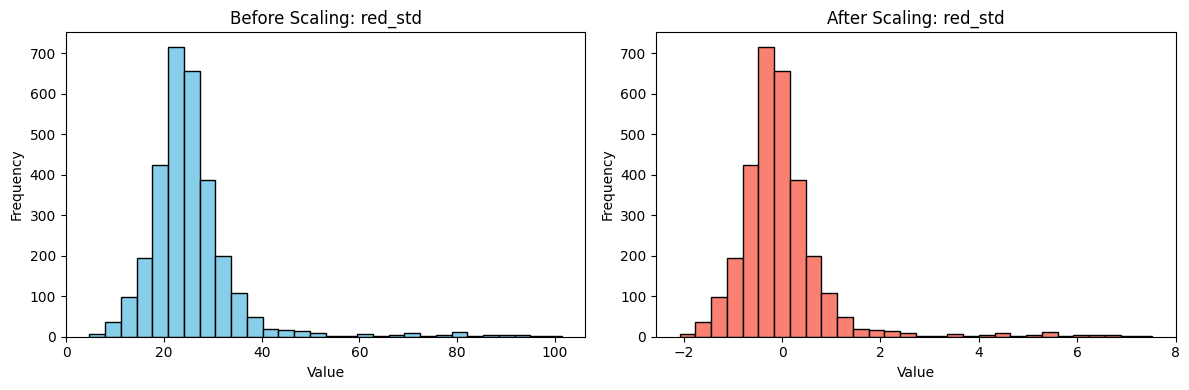

In [8]:
X.columns = X.columns.astype(str)

X_numeric = X.select_dtypes(include=['number'])

# Scale the numeric features
scaler = StandardScaler()
X_after_array = scaler.fit_transform(X_numeric)

# Convert scaled data back to DataFrame
X_after = pd.DataFrame(X_after_array, columns=X_numeric.columns)

feature_name = X_numeric.columns[23]  # or any index
plot_distribution_before_after(X_numeric, X_after, feature_name)

In [9]:
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

X_train, X_test, y_train, y_test = train_test_split(X_after, y.values.ravel(), test_size=0.2, stratify=y, random_state=42)


In [10]:


# ## SVM
print("\n=== SVM (Optimized) ===")
svm_params = {
     'C': [0.01, 0.1, 1, 10, 100],  # Test the C with exponential steps , we will choose the proper C below
     'gamma': ['scale', 'auto'],
     'kernel': ['rbf', 'linear' ]
 }
svm = GridSearchCV(SVC(), svm_params, cv=3, n_jobs=-1)
svm.fit(X_train, y_train)
print(f"Best params: {svm.best_params_}")
y_pred_svm = svm.predict(X_test)                                        
print(classification_report(y_test, y_pred_svm))




=== SVM (Optimized) ===
Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.60      0.61      0.61       204
           1       0.58      0.61      0.60       201
           2       0.83      0.78      0.81       195

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600



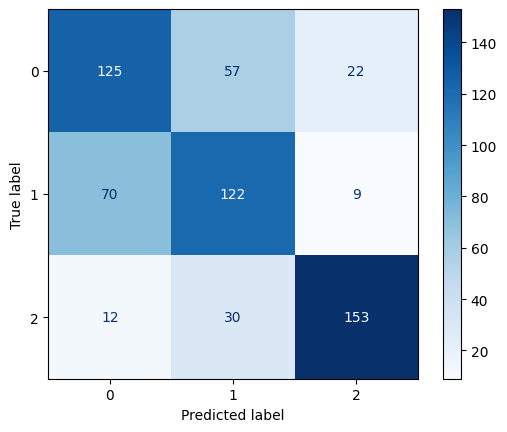

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Optional: use a colormap for better visual


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot and save
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Save the plot
plt.title("SVM Confusion Matrix")
plt.savefig("svm_confusion_matrix.png", dpi=300, bbox_inches='tight')  # Adjust name/format if needed
plt.close()  # Close the figure so it doesn't display multiple times
